<a href="https://colab.research.google.com/github/moustafa-7/UNet-Semantic-Segmentation/blob/master/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install kaggle-cli
# !pip install -U kaggle-cli
!pip install kaggle

In [0]:

!mkdir .kaggle
!touch .kaggle/kaggle.json

In [13]:
!mv .kaggle /root/

mv: cannot move '.kaggle' to '/root/.kaggle': Directory not empty


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [25]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [22]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 190, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.


In [0]:
token = {"username":"moustafa777","key":"287c52fe6188a95a1e59bd17f0b12747"}

In [0]:
import json

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [26]:
!kaggle datasets list -s tsg

ref                                        title                               size  lastUpdated          downloadCount  
-----------------------------------------  ---------------------------------  -----  -------------------  -------------  
integmind/tsg-salt-superres-training-data  tsg salt: Super-Res Training data  641MB  2018-11-04 21:20:05             23  


In [27]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 48.2MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 36.2MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 60.5MB/s]
 94% 153M/163M [00:02<00:00, 55.6MB/s]
100% 163M/163M [00:02<00:00, 58.6MB/s]
 87% 33.0M/37.9M [00:00<00:00, 20.0MB/s]
100% 37.9M/37.9M [00:00<00:00, 45.4MB/s]


In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [29]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.layers import Conv2D, BatchNormalization, Activation

Using TensorFlow backend.


In [0]:

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


## **In this part I will load the data_set**

In [0]:
im_height = 128
im_width = 128
border = 5

In [0]:
os.chdir("/content/{/content}/competitions/tgs-salt-identification-challenge")

In [0]:
#os.chdir("/{/content}/competitions/tgs-salt-identification-challenge")
!unzip train

In [0]:
ids = next(os.walk("images"))[2]

In [0]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [36]:
for n, id_ in tqdm_notebook(enumerate(ids), total = len(ids)):
  img = load_img("images/"+id_, grayscale = True)
  x_img = img_to_array(img)
  x_img = resize(x_img, (128,128,1), mode = 'constant', preserve_range = True)
  
  mask = img_to_array(load_img("masks/"+ id_, grayscale = True))
  mask = resize(mask, (128,128,1), mode = 'constant', preserve_range = True)
  
  X[n] = x_img / 255.0
  y[n] = mask/ 255.0

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = 42)

## Visulalizing the data

Text(0.5, 1.0, 'Salt')

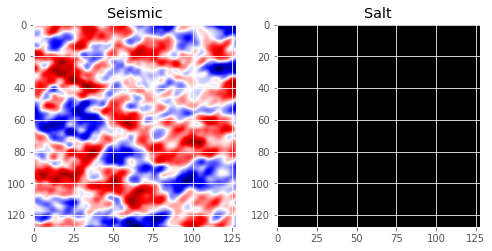

In [49]:
ix = random.randint(0,len(X_train))
has_mask = y_train[ix].max() > 0

fig, (ax1,ax2,) = plt.subplots(1, 2, figsize = (8,6))
ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

## Building the model architecture

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  x= Conv2D(n_filters, kernel_size = (kernel_size,kernel_size) , padding = 'same',kernel_initializer = 'he_normal' )(input_tensor)
  
  if batchnorm:
    x= BatchNormalization()(x)
    
  x = Activation('relu')(x)
  
#   # second layer
#   x= Conv2D(n_filters, kernel_size = (kernel_size,kernel_size) , padding = 'same',kernel_initializer = 'he_initializer' )(input_tesnor)
  
#   if batchnorm:
#     x= BatchNormalization()(x)
    
#   x = Activation('relu')(x)

  return x

In [0]:

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  # Contracting Path
  c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)

  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [0]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
max_poolin

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [55]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3600/3600 [==============================] - 22s 6ms/step - loss: 0.3929 - acc: 0.8354 - val_loss: 0.6694 - val_acc: 0.7417

Epoch 00001: val_loss improved from inf to 0.66942, saving model to model-tgs-salt.h5
Epoch 2/50
3600/3600 [==============================] - 19s 5ms/step - loss: 0.3004 - acc: 0.8740 - val_loss: 0.5025 - val_acc: 0.8069

Epoch 00002: val_loss improved from 0.66942 to 0.50245, saving model to model-tgs-salt.h5
Epoch 3/50
3600/3600 [==============================] - 19s 5ms/step - loss: 0.2669 - acc: 0.8871 - val_loss: 0.4444 - val_acc: 0.8336

Epoch 00003: val_loss improved from 0.50245 to 0.44436, saving model to model-tgs-salt.h5
Epoch 4/50
3600/3600 [==============================] - 19s 5ms/step - loss: 0.2550 - acc: 0.8914 - val_loss: 0.5035 - val_acc: 0.8069

Epoch 00004: val_loss did not improve from 0.44436
Epoch 5/50
3600/3600 [==============================] - 19s 5ms/step - loss: 0.2427 - acc: 0

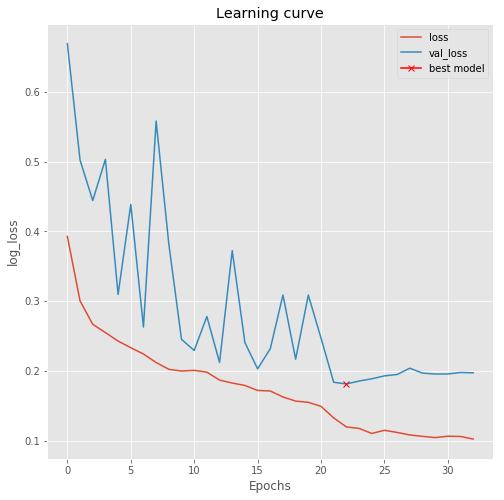

In [56]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();